In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import math

In [2]:
is_gpu = True
gpu_id = 0
batch_size = 100
num_workers= 4
num_epochs = 1
init_lr = 1e-5
max_lr = 1e-3
min_lr = 1e-5
lr_scheduler = 'Cyclical' #'Cyclical', 'SGDR'
epochs_per_cycle = 0.2

In [3]:
class CustomLR(_LRScheduler):
    def __init__(self, optimizer, last_epoch=-1, max_lr=1e-3, min_lr=1e-5):
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.history = {}

        super(CustomLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        raise NotImplementedError

    # for history
    def append_loss_history(self, loss):
        self.history.setdefault('loss', []).append(loss)

    def append_lr_history(self, new_lr):
        self.history.setdefault('lr', []).append(new_lr)
        self.history.setdefault('iterations', []).append(self._step_count)

# Cyclical learning rates
class CyclicalLR(CustomLR):
    def __init__(self, optimizer, step_size, last_epoch=-1, max_lr=1e-3, min_lr=1e-5, mode="triangular", gamma=0.94):

        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma # for exp_range


        if mode == 'triangular':
            self.scale_fn = lambda x : 1
        elif mode == 'triangular2':
            self.scale_fn = lambda x : 1 / 2 ** (x - 1)
        elif mode == 'exp_range':
            self.scale_fn = lambda x : self.gamma ** (x)
        else:
            raise NotImplementedError

        super(CyclicalLR, self).__init__(optimizer, last_epoch)
        
    def get_lr(self):
        prg = self._step_count / self.step_size

        cycle = math.floor(1 + prg / 2)
        x = abs(prg - 2 * cycle + 1)
        new_lr = self.min_lr + (self.max_lr - self.min_lr) * max(0, 1 - x) * self.scale_fn(cycle)

        self.history.setdefault('cycle', []).append(cycle)
        self.history.setdefault('x', []).append(x)
        self.append_lr_history(new_lr)

        # because these schedulers are not calculated using previous learning rate
        # So all learning rates are same
        return [new_lr] * len(self.base_lrs)
# Stochastic Gradient Descent with Restarts (SGDR)
class SGDRLR(CustomLR):
    def __init__(self, optimizer, step_size, last_epoch=-1, max_lr=1e-3, min_lr=1e-5):
        self.step_size = step_size

        super(SGDRLR, self).__init__(optimizer, last_epoch, max_lr, min_lr)

    def get_lr(self):
        # the number of steps since the last restart
        curr_step = self._step_count % self.step_size
        new_lr = self.min_lr + (self.max_lr - self.min_lr) / 2 * (1 + math.cos(curr_step / self.step_size * math.pi))

        self.append_lr_history(new_lr)

        return [new_lr] * len(self.base_lrs)

In [4]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

data_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Files already downloaded and verified


In [5]:
mobilenet = models.mobilenet_v2(pretrained=True)
model_fm = mobilenet.classifier[1].in_features
mobilenet.classifier = nn.Sequential(
    nn.Linear(model_fm, 10),
    nn.Softmax(dim=1)
)

if is_gpu:
    mobilenet = mobilenet.cuda(gpu_id)

In [6]:
loss_func = nn.CrossEntropyLoss()
optm = optim.Adam(mobilenet.parameters(), lr=init_lr)

In [7]:
steps_per_epoch = len(loader_train)
# calc. steps per cycle
step_size = math.ceil(steps_per_epoch * epochs_per_cycle)

In [8]:
if lr_scheduler == 'Cyclical':
    lr_schd = CyclicalLR(optm, step_size=math.ceil(step_size / 2), max_lr=max_lr, min_lr=min_lr, mode="triangular", gamma=0.94)
else:
    lr_schd = SGDRLR(optm, step_size=step_size, max_lr=max_lr, min_lr=min_lr)

In [9]:
mobilenet.train(True)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [10]:
# total step size
progress_bar = tqdm_notebook(total=(steps_per_epoch * num_epochs))
for epoch in range(num_epochs):
    for step, data_batch in enumerate(loader_train, 0):
        inputs, labels = data_batch

        optm.zero_grad()

        if is_gpu:
            inputs = inputs.cuda(gpu_id)
            labels = labels.cuda(gpu_id)
            logits = mobilenet(inputs.cuda())
            loss = loss_func(logits, labels.cuda())
        else:
            logits = mobilenet(inputs)
            loss = loss_func(logits, labels)

        loss.backward()
        optm.step()
        lr_schd.step()
        lr_schd.append_loss_history(loss.item())

        if step % 10 == 0:
            progress_bar.update(10)

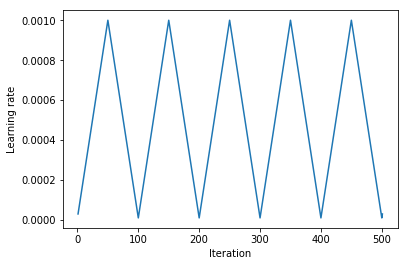

In [11]:
plt.plot(lr_schd.history['iterations'], lr_schd.history['lr'])
plt.xlabel('Iteration')
plt.ylabel('Learning rate')
plt.show()

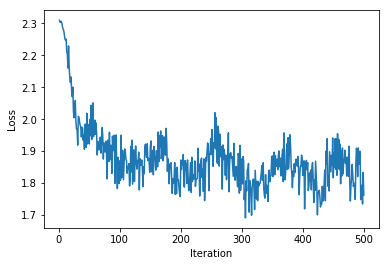

In [12]:
plt.plot(lr_schd.history['iterations'][:-1], lr_schd.history['loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

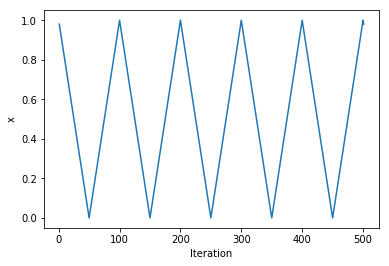

In [13]:
plt.plot(lr_schd.history['iterations'], lr_schd.history['x'])
plt.xlabel('Iteration')
plt.ylabel('x')
plt.show()

In [66]:
del mobilenet